This Python script computes the optimum efficiency of an alkaline electrolysis system for hydrogen production at various temperatures by optimizing the current density. the symbolic library sympy is utilsed in this model 

In [ ]:
# Model dependancies 
import numpy as np
import math
from sympy import symbols, diff, solve,log,lambdify

In [ ]:

# function to compute the efficienct @ specific current density ,temperatures and pressures  

def Efficiency_func (temperature,pressure,current_density,numerical=False):
    
    numerical= numerical
    T=temperature
    T_K= T+273.15
    Erev_T_1 = (1.5184-(1.5421*10**-3)*T_K)+(9.523*10**-5*T_K*np.log(T_K))+(9.84*10**-8*T_K**2)  # standard Reversible voltage
    R=8.3145
    F=96485
    p=pressure
    p_expression = ((3*R*T_K)/(4*F))*math.log(p)  # Expression accounting for pressure 
    Erev_T_p = Erev_T_1 + p_expression  # Reversible voltage at T and P
  # Overvoltages parameters 
    # Activation overvoltages parameters
    i=current_density
    s =0.33824 
    t1 =-0.01539 
    t2 =2.00181
    t3 =15.24178
    logterm=(t1+(t2/T)+(t3/T**2))
    
    if(numerical==True):
        ActivationOV= s*(np.log10((logterm*(i))+1))
    else:
        ActivationOV= s*(log((logterm*(i))+1,10))
        
    # Ohmic OverPotential 
    # r and d coefficients parameters 
    r1 = 4.45153*10**-5
    r2 =6.88874*10**-9 
    d1 =-3.12996*10**-6 
    d2 =4.47137*10**-7 
    OhmicOV= ((r1 + d1) +(r2*T)  + (d2*p))*i
    Ecell= Erev_T_p + ActivationOV + OhmicOV

    # Faraday coefficients 
    f11=478645.74
    f12=-2953.15
    f21= 1.03960
    f22=-0.00104
    faraday_eff=(i**2/(f11+f12+i**2))*(f21+(f22*T))
    # Energy Efficiency 
    eff_E =   Erev_T_p/ Ecell
    # Overall efficiency
    eff=eff_E*faraday_eff
    return eff







In [ ]:
# Import optimizers from scipy
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from scipy.optimize import differential_evolution
from scipy.optimize import shgo
from scipy.optimize import basinhopping

i=symbols('i') # Declaring symbolic current density variable
temperatures = np.arange(25,90) # Temperature range
p= 1 #atm 
lower_bound = 0 # Define the algorithm lower bound 
upper_bound = 7000  # Define the upper bound 

# Function to compute optimal efficiency, takes in temperatures , pressure and symbolic current density (i)
def eff_optimization (temperatures,pressure,current):
    i= current
    optimum_values_i=[]
    optimum_values_eff=[]
    # looping for each temperature in the list 
    for temperature in temperatures:
        # call the efficiency function
        efficiency_eq_i= Efficiency_func(temperature,pressure,i)

        # Compute the derivative of the efficiency function with respect to i . this expression can be printed for presentation, as given in the accompagnying article
        efficiency_derivative = diff( efficiency_eq_i,i)

        # Turn the symbolic equation into a function with lamdify 
        efficiency_derivative_func = lambdify(i, efficiency_derivative, 'numpy')

        # Define the objective function for optimization 
        objective_function = lambda x: abs(efficiency_derivative_func(x))

        # Use minimize_scalar numerical optimization routine to find the critical points
        result = minimize_scalar(objective_function, bounds=(lower_bound, upper_bound), method='bounded')

        # Get the optimal current density value
        optimal_current_density = result.x
        # Get the optimal efficiency value 
        optimal_efficiency = Efficiency_func(temperature,pressure,optimal_current_density,numerical=True)
        
        # Appending values of optimal efficiency and current density to corresponding lists for each temperature 
        optimum_values_i.append(optimal_current_density)
        optimum_values_eff.append(optimal_efficiency)
    
    return  optimum_values_i,optimum_values_eff



In [4]:
Optimum_efficiecy=eff_optimization(temperatures,p,i)
Optimum_efficiecy[0]



[2716.5998235973625,
 2711.418520469982,
 2706.393058521767,
 2701.510977157776,
 2696.7610786150126,
 2692.133333110164,
 2687.6187697276814,
 2683.2093182806134,
 2678.8976348797737,
 2674.6771560482844,
 2670.5417962412203,
 2666.4860616050587,
 2662.504982681121,
 2658.593814325896,
 2654.748428834706,
 2650.9648601360636,
 2647.239501985558,
 2643.5689703384096,
 2639.9502275378563,
 2636.3803164207657,
 2632.8565939394716,
 2629.376560626601,
 2625.9378459388445,
 2622.538236261574,
 2619.1757345047927,
 2615.848367783186,
 2612.5543164583364,
 2609.2919166921106,
 2606.0595113720447,
 2602.855614205392,
 2599.67876411891,
 2596.527622830005,
 2593.4008859480778,
 2590.2973641066797,
 2587.215875231296,
 2584.1553214244886,
 2581.114696230574,
 2578.092999020393,
 2575.0893035472573,
 2572.102662643622,
 2569.132246078739,
 2566.177284340787,
 2563.236977432267,
 2560.3106162850536,
 2557.3974598715604,
 2554.496921384488,
 2551.6083770199452,
 2548.7311845252193,
 2545.864839314

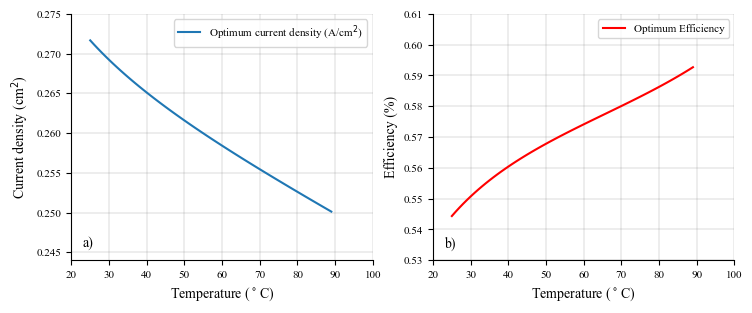

In [ ]:
# plotting 
import matplotlib.pyplot as plt # model for plotting 

optimum_i_cm2= np.array(Optimum_efficiecy[0])/10000
optimum_efficiency_list= np.array(Optimum_efficiecy[1])

plt.rcParams["font.family"] = "Times New Roman "

# Plotting 
Fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8.555, 3.2))
Fig.subplots_adjust( hspace=0.3) 

# Plot optimum current density vs temperature and optimum efficiency density vs temperature
ax1.set_ylabel('Current density (cm$^{2}$)',fontsize=10)
ax1.set_xlabel('Temperature ($^\circ$C)',animated=True,fontsize=10)

ax1.set_xlim(20,100)
ax1.set_ylim(0.244,0.275)

ax1.text(23, 0.2457, 'a)',fontsize=10,)
ax2.text(23, 0.534, 'b)',fontsize=10,)

ax2.set_xlabel('Temperature ($^\circ$C)',animated=True,fontsize=10)
ax2.set_ylabel('Efficiency (%)',fontsize=10)

ax2.tick_params(axis='both', labelsize=8)  
ax1.tick_params(axis='both', labelsize=8)  
ax2.set_xlim(20,100)
ax2.set_ylim(0.53,0.61)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax1.grid(color='gray', linewidth=0.2, alpha=1)
ax2.grid(color='gray', linewidth=0.2, alpha=1)

ax1.plot(temperatures,optimum_i_cm2,label=f'Optimum current density (A/cm$^{2}$)')

ax2.plot(temperatures,optimum_efficiency_list,color='red',label=f'Optimum Efficiency')

ax1.legend(loc="upper right",prop={'size':8})
ax2.legend(loc="upper right",prop={'size':8})

# saving figure 
Fig.savefig("images/opti.tiff", format='tiff', dpi=500, bbox_inches='tight',bbox_extra_artists=[ax1.yaxis.label, ax2.yaxis.label],pil_kwargs={"compression": "tiff_lzw"})